In [2]:
import torch
from sklearn.manifold import TSNE
from matplotlib import pyplot
import sys
sys.path.append('..')
tsne = TSNE(n_components=2, n_iter=5000, init='pca', verbose=1)

In [3]:
distributed = False
gpu = 2
batch_size = 256
workers = 8
num_classes = 10
def prepare_model(model):
    if not torch.cuda.is_available():
        print('using CPU, this will be slow')
        return model
    elif distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if args.gpu is not None:
            torch.cuda.set_device(gpu)
            model.cuda(gpu)
            # When using a single GPU per process and per
            # DistributedDataParallel, we need to divide the batch size
            # ourselves based on the total number of GPUs we have
            batch_size = int(batch_size / ngpus_per_node)
            workers = int((workers + ngpus_per_node - 1) / ngpus_per_node)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[gpu])
            return model
        else:
            model.cuda()
            model = torch.nn.parallel.DistributedDataParallel(model)
            return model
    elif gpu is not None:
        torch.cuda.set_device(gpu)
        model = model.cuda(gpu)
        return model
    else:
        # DataParallel will divide and allocate batch_size to all available GPUs
        model = torch.nn.DataParallel(model).cuda()
        return model

In [4]:
from torchvision.datasets import CIFAR10,CIFAR100
import datafree
import registry
student = registry.get_model('resnet18', num_classes=num_classes)
teacher = registry.get_model('resnet34', num_classes=num_classes, pretrained=True).eval()
normalizer = datafree.utils.Normalizer(**registry.NORMALIZE_DICT['cifar10'])
student = prepare_model(student)
teacher = prepare_model(teacher)
teacher.load_state_dict(torch.load('../checkpoints/scratch/cifar10_resnet34.pth', map_location='cpu')['state_dict'])
teacher.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [16]:
pretrained_weight = {
    'gan': '/data1/lijingru/gan-vae-pretrained-pytorch/cifar10_dcgan/weights/netG_epoch_199.pth',
    'ddpm': '/tmp/openai-2022-07-02-15-15-09-089368/samples_100000x32x32x3.npz',
    'ebm': '/data1/lijingru/JEMPP/runs/JEMPP/cifar10/0706093019@JEMPP-n_steps=10-in_steps=5-pyld_lr=0.2@43419/best_valid_ckpt.pt_eval_uncond_samples_0708024016/buffer.pt',
    'sde_ode': '/data1/lijingru/score_sde_pytorch/save/ode/',
    'sde_pc': '/data1/lijingru/score_sde_pytorch/save/pc/',
}
normalizer = datafree.utils.Normalizer(**registry.NORMALIZE_DICT['cifar10'])

### Pretrained GAN
tSNE result for pretrained GANs.

In [17]:
G = datafree.models.generator.pretrained_DCGAN_Generator(ngpu=1, nz=100, ngf=64)
ckpt = torch.load(pretrained_weight['gan'], map_location='cpu')
G.load_state_dict(ckpt)
G.eval()
G = G.to(gpu)

In [18]:
def tsne_res(t_feat, t_out):
    X_real = tsne.fit_transform(t_feat.cpu().numpy())
    y_real = np.argmax(t_out.cpu().numpy(), 1)
    pyplot.scatter(X_real[:, 0], X_real[:, 1], c=y_real)

/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.000s...
[t-SNE] Computed neighbors for 256 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 2.165041
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.771069
[t-SNE] KL divergence after 1250 iterations: 0.533074


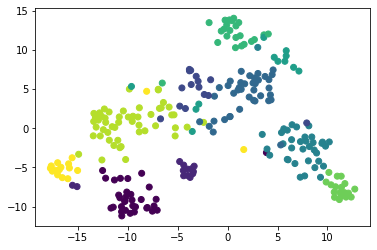

In [19]:
import numpy as np
batch_size = 256
z = torch.randn(size=(batch_size, 100), device=gpu)
# t_feats = []
with torch.no_grad():
    samples = G(z)
    t_out, t_feat = teacher(normalizer(samples), return_features=True)

tsne_res(t_feat, t_out)

/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.000s...
[t-SNE] Computed neighbors for 256 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 2.268825
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.074612
[t-SNE] KL divergence after 1400 iterations: 0.346323


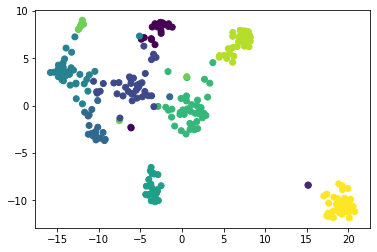

In [22]:
ckpt = torch.load(pretrained_weight['ebm'], map_location='cpu')
replay_buffer = ckpt['replay_buffer']
replay_buffer = torch.clamp((replay_buffer + 1) / 2, 0, 1)
# replay_buffer = replay_buffer.to(gpu)
random_idx = torch.randint(0, replay_buffer.size(0), (256, ))
samples = replay_buffer[random_idx]
samples = samples.to(gpu)

with torch.no_grad():
    t_out, t_feat = teacher(normalizer(samples), return_features=True)
    
tsne_res(t_feat, t_out)
# replay_buffer = replay_buffer.numpy()
# replay_buffer = replay_buffer.clamp_(0, 1) * 255
# replay_buffer = [Image.fromarray(x) for x in replay_buffer.permute(0,2,3,1).numpy().astype(np.uint8)]

/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.001s...
[t-SNE] Computed neighbors for 256 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 2.680598
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.508617
[t-SNE] KL divergence after 1800 iterations: 0.289933


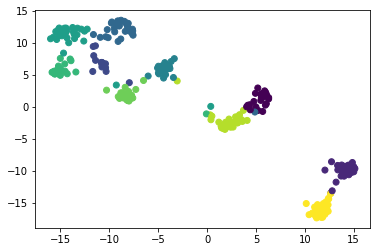

In [25]:
import torchvision.transforms as T
from PIL import Image
replay_buffer = np.load(pretrained_weight['ddpm'])
replay_buffer = torch.stack([T.ToTensor()(Image.fromarray(x)) for x in replay_buffer['arr_0']], 0)
random_idx = torch.randint(0, replay_buffer.size(0), (256, ))
samples = replay_buffer[random_idx]
samples = samples.to(gpu)

with torch.no_grad():
    t_out, t_feat = teacher(normalizer(samples), return_features=True)
    
tsne_res(t_feat, t_out)

/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.001s...
[t-SNE] Computed neighbors for 256 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 2.811330
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.500282
[t-SNE] KL divergence after 1350 iterations: 0.166836


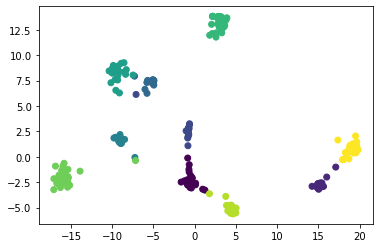

In [30]:
import os
all_npzs = os.listdir(pretrained_weight['sde_ode'])
replay_buffer = []
for npz in all_npzs:
    npz_dir = os.path.join(pretrained_weight['sde_ode'], npz)
#     print(npz_dir)
    if npz_dir.endswith('.npz'):
        npz_load = np.load(npz_dir)
        images = [T.ToTensor()(Image.fromarray(x)) for x in npz_load['samples']]
        replay_buffer.extend(images)
    
replay_buffer = torch.stack(replay_buffer, 0)
random_idx = torch.randint(0, replay_buffer.size(0), (256, ))
samples = replay_buffer[random_idx]
samples = samples.to(gpu)

with torch.no_grad():
    t_out, t_feat = teacher(normalizer(samples), return_features=True)
    
tsne_res(t_feat, t_out)

/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.001s...
[t-SNE] Computed neighbors for 256 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 2.711166
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.440964
[t-SNE] KL divergence after 1250 iterations: 0.120985


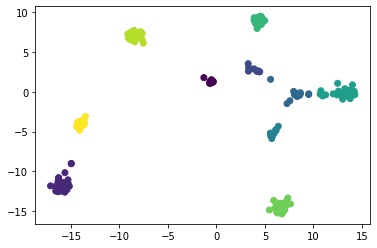

In [31]:
import os
all_npzs = os.listdir(pretrained_weight['sde_pc'])
replay_buffer = []
for npz in all_npzs:
    npz_dir = os.path.join(pretrained_weight['sde_pc'], npz)
#     print(npz_dir)
    if npz_dir.endswith('.npz'):
        npz_load = np.load(npz_dir)
        images = [T.ToTensor()(Image.fromarray(x)) for x in npz_load['samples']]
        replay_buffer.extend(images)
    
replay_buffer = torch.stack(replay_buffer, 0)
random_idx = torch.randint(0, replay_buffer.size(0), (256, ))
samples = replay_buffer[random_idx]
samples = samples.to(gpu)

with torch.no_grad():
    t_out, t_feat = teacher(normalizer(samples), return_features=True)
    
tsne_res(t_feat, t_out)